# N-dimensional nonlinear inversion

The user manually builds their own forward model (and adjoint model, for now). The forward model is constructed using components of the Inversion module. This affords us more flexibility without writing many lines of code.

This module calls the ConductionND module, which can be accessed directly from the .mesh attribute.

In [1]:
import numpy as np
from conduction import ConductionND
from conduction import InversionND
from petsc4py import PETSc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
minX, maxX = 0.0, 1000.0
minY, maxY = 0.0, 1000.0
minZ, maxZ = -35e3, 1000.0
nx, ny, nz = 10, 9, 10
n = nx*ny*nz

mesh = ConductionND((minX, minY, minZ), (maxX, maxY, maxZ), (nx,ny,nz))

# BCs
mesh.boundary_condition('maxZ', 298.0, flux=False)
mesh.boundary_condition('minZ', 0.04, flux=True)

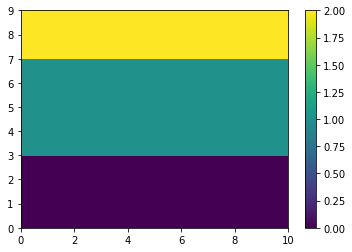

In [3]:
lithology = np.zeros((nz,ny,nx), dtype='int32')
lithology[:,3:7,:] = 1
lithology[:,7:,:]  = 2

plt.pcolor(lithology[5,:,:])
plt.colorbar()

In [4]:
def hofmeister1999(k0, T, a=0.25, c=0.0):
    return k0*(298.0/T)**a + c*T**3

def hofmeister1999_ad():
    pass

In [176]:
def forward_model(self, x, bc='Z'):
    k_list, H_list, a_list = np.array_split(x[:-1], 3)
    q0 = x[-1]
    
    # map to mesh
    k0, H, a = self.map(k_list, H_list, a_list)
    k = k0.copy()
    
    self.mesh.boundary_condition("max"+bc, 298.0, flux=False)
    self.mesh.boundary_condition("min"+bc, q0, flux=True)
    rhs = self.mesh.construct_rhs()
    
    error = 10.
    tolerance = 1e-5
    i = 0
    while error > tolerance:
        k_last = k.copy()
        self.mesh.diffusivity[:] = k
        self.mesh.update_properties(k, H)
        T = self.linear_solve(rhs=rhs) # solve
        k = hofmeister1999(k0, T, a)
        error = np.absolute(k - k_last).max()
        i += 1
    print("{} iterations".format(i))
        
    q = self.heatflux(T, k)
    delT = self.gradient(T)
    
    cost = 0.0
    cost += self.objective_routine(q=q[0], T=T, delT=delT[0]) # observations
    cost += self.objective_routine(k=k_list, H=H_list, a=a_list, q0=q0) # priors
    return cost

In [177]:
def adjoint_model(self, x, bc='Z'):
    k_list, H_list, a_list = np.array_split(x[:-1], 3)
    q0 = x[-1]
    
    # map to mesh
    k0, H, a = self.map(k_list, H_list, a_list)
    k = [k0.copy()]
    T = [None]
    
    self.mesh.boundary_condition("max"+bc, 298.0, flux=False)
    self.mesh.boundary_condition("min"+bc, q0, flux=True)
    rhs = self.mesh.construct_rhs()
    self.mesh.heat_sources[:] = H
    
    error = 10.
    tolerance = 1e-5
    i = 0
    self.mesh.temperature._gdata.set(0.)
    while error > tolerance:
        self.mesh.diffusivity[:] = k[i]
        # solve
        Ti = self.linear_solve(rhs=rhs)
        ki = hofmeister1999(k0, Ti, a)
        T.append(Ti.copy())
        k.append(ki.copy())
        error = np.absolute(k[-1] - k[-2]).max()
        i += 1
    print("{} iterations".format(i))

    q = self.heatflux(T[-1], k[-1])
    delT = self.gradient(T[-1])
    
    cost = 0.0
    cost += self.objective_routine(q=q[0], T=T[-1], delT=delT[0]) # observations
    cost += self.objective_routine(k=k_list, H=H_list, a=a_list, q0=q0) # priors
    
    ## AD ##
    dk = np.zeros_like(H)
    dH = np.zeros_like(H)
    dT = np.zeros_like(H)
    da = np.zeros_like(H)
    dk0 = np.zeros_like(H)
    dq0 = np.array(0.0)
    
    # priors
    dcdk_list = self.objective_routine_ad(k=k_list)
    dcdH_list = self.objective_routine_ad(H=H_list)
    dcda_list = self.objective_routine_ad(a=a_list)
    dcdq0 = self.objective_routine_ad(q0=q0)
    # observations
    dT += self.objective_routine_ad(T=T[-1])

    dq = np.zeros_like(q)
    dq[0] = self.objective_routine_ad(q=q[0])
    
    ddelT = np.zeros_like(delT)
    ddelT[0] = self.objective_routine_ad(delT=delT[0])
    

    dTd = self.gradient_ad(ddelT, T[-1])
    dT += dTd
    
    dTq, dkq = self.heatflux_ad(dq, q, T[-1], k[-1])
    dT += dTq
    dk += dkq
    

    # solve
    for j in xrange(0, i):
        dkda = np.log(298.0/T[-1-j])*k0*(298.0/T[-1-j])**a
        dkdk0 = (298.0/T[-1-j])**a
        dkdT = -a*k0/T[-1-j]*(298.0/T[-1-j])**a
        
        dk0 += dkdk0*dk
        dT  += dkdT*dk
        da  += dkda*dk
        print dT.min(), dT.max(), dk.min(), dk.max()
        
        dk.fill(0.0)
        
#         print j, dT
        self.mesh.diffusivity[:] = k[-1-j]
        dA, db = self.linear_solve_ad(T[-1-j], dT)
#         print j, dA
        dk += dA
        dH += -db
        dz = self.grid_delta[-1]
        lowerBC_mask = self.mesh.bc["min"+bc]["mask"]
        dq0 += np.sum(-db[lowerBC_mask]/dz/inv.ghost_weights[lowerBC_mask])
        
#         dT.fill(0.0)
        
    dk0 += dk
        
    # pack to lists
    dk_list, dH_list, da_list = inv.map_ad(dk, dH, da)
    dk_list += dcdk_list
    dH_list += dcdH_list
    da_list += dcda_list
    dq0 += dcdq0
    
    dx = np.hstack([dk_list, dH_list, da_list, [dq0]])
    
    return cost, dx

In [178]:
inv = InversionND(lithology.flatten(), mesh)

k = np.array([3.5, 2.0, 3.2])
H = np.array([0.1e-6, 1e-6, 2e-6])
a = np.array([0.25, 0.25, 0.25])*0.0
q0 = 35e-3

x = np.hstack([k, H, a, [q0]])
dx = x*0.01

# Priors
k_prior = k*1.1
H_prior = H*1.1
a_prior = a*1.1
q0_prior = np.array(30e-3)

sigma_k = k*0.1
sigma_H = H*0.1
sigma_a = a*0.1
sigma_q0 = np.array(5e-3)

In [179]:
from conduction.inversion import InvObservation, InvPrior

kp = InvPrior(k_prior, sigma_k)
Hp = InvPrior(H_prior, sigma_H)
ap = InvPrior(a_prior, sigma_a)
q0p = InvPrior(q0_prior, sigma_q0)

inv.add_prior(k=kp, H=Hp, q0=q0p)

fm0 = forward_model(inv, x)
fm1 = forward_model(inv, x+dx)
ad = adjoint_model(inv, x)

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

1 iterations
1 iterations
1 iterations
0.0 0.0 0.0 0.0
finite difference -0.9951
adjoint -1.06


In [180]:
inv = InversionND(lithology.flatten(), mesh)

ndelT = 50

delT = np.ones(ndelT)*1e3
sigma_delT = ndelT*0.001
delT_coord = np.zeros((ndelT,3))
delT_coord[:,0] = np.linspace(minX, maxX, ndelT)
delT_coord[:,1] = np.linspace(minY, maxY, ndelT)
delT_coord[:,2] = np.linspace(minZ, maxZ, ndelT)

delTobs = InvObservation(delT, sigma_delT, delT_coord)

inv.add_observation(delT=delTobs)

In [181]:
fm0 = forward_model(inv, x)
fm1 = forward_model(inv, x+dx)
ad = adjoint_model(inv, x)

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

1 iterations
1 iterations
1 iterations
delT (900,) (50,) (900,)
-600.014870966 600.014870966 0.0 0.0
finite difference -2640.98338699
adjoint -26.6708088276


There is something wrong with the way dT is propogated!!

In [158]:
inv = InversionND(lithology.flatten(), mesh)

nqs = 500

qs = np.ones(nqs)*0.03
sigma_qs = qs*0.5
qs_coord = np.zeros((nqs,3))
qs_coord[:,0] = np.linspace(minX, maxX, nqs)
qs_coord[:,1] = np.linspace(minY, maxY, nqs)
qs_coord[:,2] = np.linspace(minZ, maxZ, nqs)


qobs = InvObservation(qs, sigma_qs, qs_coord)

inv.add_observation(q=qobs)

In [159]:
fm0 = forward_model(inv, x)
fm1 = forward_model(inv, x+dx)
ad = adjoint_model(inv, x)

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

6 iterations
6 iterations
6 iterations
q (900,) (500,) (900,)
-11.3007175822 10.403409672 0.0 558.001485701
0.0 0.121211538281 -45.1512980098 0.0
0.0 0.0147926712823 -5.51027005264 0.0
0.0 0.00180280041532 -0.671543154706 0.0
0.0 0.000219671406091 -0.0818275987688 0.0
0.0 2.66927455688e-05 -0.0099430477244 0.0
finite difference 36.600233283
adjoint 62.5596775717


In [124]:
inv = InversionND(lithology.flatten(), mesh)

size = 50
cxy = np.empty((size,3))
cxy[:,0] = np.random.uniform(minX, maxX, size)
cxy[:,1] = np.random.uniform(minY, maxY, size)
cxy[:,2] = np.random.uniform(minZ, maxZ, size)

Tp = np.ones(size)*50
sigma_Tp = 0.1*Tp

Tobs = InvObservation(Tp, sigma_Tp, cxy)
inv.add_observation(T=Tobs)

In [125]:
fm0 = forward_model(inv, x)
fm1 = forward_model(inv, x+dx)
ad = adjoint_model(inv, x)

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

2 iterations
2 iterations
1 iterations
T (900,) (50,) (900,)
0.0 75.6730101705 0.0 0.0
finite difference -4351.91284181
adjoint -44.119569217


In [126]:
inv = InversionND(lithology.flatten(), mesh)

Tp = np.ones(lithology.size)*50
sigma_Tp = 0.01*Tp

Tobs = InvObservation(Tp, sigma_Tp, mesh.coords)
inv.add_observation(T=Tobs)

In [127]:
fm0 = forward_model(inv, x)
fm1 = forward_model(inv, x+dx)
ad = adjoint_model(inv, x)

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

2 iterations
2 iterations
1 iterations
T (900,) (900,) (900,)
1984.0 7567.34280437 0.0 0.0
finite difference -8030096.89319
adjoint -81410.6965875


## 2D version

In [16]:
minX, maxX = 0.0, 1000.0
minY, maxY = -35e3, 1000.0
nx, ny = 10, 9
n = nx*ny

mesh = ConductionND((minX, minZ), (maxX, maxZ), (nx,ny))

# BCs
mesh.boundary_condition('maxY', 298.0, flux=False)
mesh.boundary_condition('minY', 0.04, flux=True)

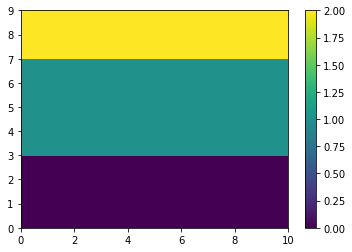

In [17]:
lithology = np.zeros((ny,nx), dtype='int32')
lithology[3:7,:] = 1
lithology[7:,:]  = 2

plt.pcolor(lithology)
plt.colorbar()

In [18]:
inv = InversionND(lithology.flatten(), mesh)

# inv.add_prior(k=kp, H=Hp, q0=q0p)

In [19]:
nqs = 500

qs = np.ones(nqs)*0.03
sigma_qs = qs*0.5
qs_coord = np.zeros((nqs,2))
qs_coord[:,0] = np.linspace(minX, maxX, nqs)
qs_coord[:,1] = 0.0
qs_coord[:,1] = np.linspace(minY, maxY, nqs)

qobs = InvObservation(qs, sigma_qs, qs_coord)

inv.add_observation(q=qobs)

In [20]:
fm0 = forward_model(inv, x, bc='Y')
fm1 = forward_model(inv, x+dx, bc='Y')
ad = adjoint_model(inv, x, bc='Y')

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

q (90,) (500,) (90,)
finite difference 35.7533566606
adjoint 35.2757785526


In [21]:
inv = InversionND(lithology.flatten(), mesh)

Tp = np.ones(lithology.size)*50
sigma_Tp = 0.01*Tp

Tobs = InvObservation(Tp, sigma_Tp, mesh.coords)
inv.add_observation(T=Tobs)

In [22]:
fm0 = forward_model(inv, x, bc='Y')
fm1 = forward_model(inv, x+dx, bc='Y')
ad = adjoint_model(inv, x, bc='Y')

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

T (90,) (90,) (90,)
finite difference -0.00146660208702
adjoint -0.00877203792334
